In [1]:
# Uncomment when in Google Colab and install
!pip install opendatasets --upgrade

In [2]:
import os
os.getcwd()

'/Users/louisgodtfredsen/VisualStudioCodeProjects/birdClassification'

In [3]:
import torch
import pandas as pd
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from dataFunctions import *
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
from tqdm import tqdm
import os
import torchvision
%load_ext autoreload

%autoreload 2

/var/folders/m2/pmjxjx5x06gfn7cms40klj3h0000gn/T/ipykernel_6557/4146459266.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load in Kaggle Bird Dataset

In [4]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/gpiosenka/100-bird-species'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

Your Kaggle username:Your Kaggle Key:Downloading 100-bird-species.zip to ./100-bird-species


100%|██████████| 1.96G/1.96G [02:11<00:00, 16.0MB/s]


In [23]:
df = pd.read_csv('test_info.csv')
labels = list(df['labels'].unique())

# Data Pre-Processing

In [7]:
# Create Custom Pytorch Dataset to load in samples

train_images = BirdImageDataset('train_info.csv', True)
val_images = BirdImageDataset('valid_info.csv', False)
test_image = BirdImageDataset('test_info.csv', False)

In [8]:
# Initialise DataLoaders for

train_loader = DataLoader(train_images, batch_size = 32, shuffle= True)
val_loader = DataLoader(val_images, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_image, batch_size = 32, shuffle= True)

In [28]:
torch.where(val_images.__getitem__(idx)[1] == 1)[0].item()

160

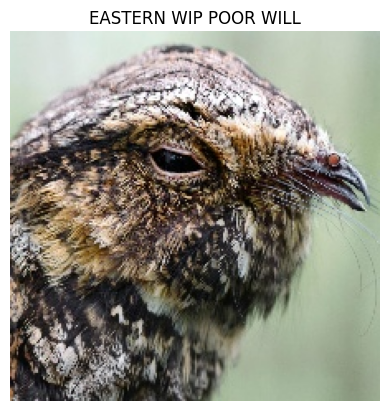

In [30]:
idx = 1000
image = val_images.__getitem__(idx)[0]

# Convert the tensor to a PIL Image
tensor_to_pil = transforms.ToPILImage()
pil_image = tensor_to_pil(image)

# Display the image using Matplotlib

plt.title(labels[torch.where(val_images.__getitem__(idx)[1] == 1)[0].item()])
plt.imshow(pil_image)
plt.axis('off')  # Hide axes
plt.show()

# Initialise Model


In [32]:
#Definition of hyperparameters
n_iters = 4500
num_epochs = 100

# Load in Pre-trained Resnet Model
model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1')
model_requires_grad_params = []

# Disable Gradients in Resnet layers as we don't want to backward propagate for optimising weights
for param in model.parameters():
    param.requires_grad = False

# Feed-forward network to switch with last layer in ResNet
class FFClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop(x)
        x = self.fc1(x)

        x = F.log_softmax(x, dim=1)
        return x

# Swap out original fc in ResNet with custom layer to match desired classifier outputs
model.fc = FFClassifier(in_features=512, out_features=525)


for param in model.parameters():

    if param.requires_grad == True:
        model_requires_grad_params.append(param)

print(model)

# Cross Entropy Loss
l = nn.CrossEntropyLoss()

# Optimizer
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)

# Device :)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Initialise Training Loop

In [34]:
total_train_loss = []
total_val_loss = [] 
model.to(device)
for epoch in tqdm(range(num_epochs)):
    print(f'\n ----EPOCH: {epoch}/{num_epochs}----')
    model.train()
    epoch_train_loss = []
    epoch_val_loss = []
    for idx, batch in enumerate(train_loader):


        train_x, train_y = batch
        
        optimizer.zero_grad()

        output = model(train_x.to(device))
        
        loss = l(output, train_y.to(device))

        loss.backward()
        epoch_train_loss.append(loss.item())

        if idx%100 == 0:
            print(f'BATCH {idx+1} Running Loss: {loss.item()}')

        # Adjust learning weights
        optimizer.step()
        
    model.eval()
    
    for idx, batch in enumerate(val_loader):
        val_x, val_y = batch
        
        output = model(val_x.to(device))
        
        loss = l(output, val_y.to(device))
        
        epoch_val_loss.append(loss)
         

    total_train_loss.append(sum(epoch_train_loss)/len(epoch_train_loss))
    total_train_loss.append(sum(epoch_val_loss)/len(epoch_val_loss))
    print(f'Epoch Train Loss: {sum(epoch_train_loss)/len(epoch_train_loss)}')
    print(f'Epoch Validation Loss: {sum(epoch_val_loss)/len(epoch_val_loss)}')

  0%|          | 0/100 [00:00<?, ?it/s]


 ----EPOCH: 0/100----


RuntimeError: [Errno 2] No such file or directory: '100-bird-species/train/AMERICAN PIPIT/003.jpg'

# Example Inference and Visualisation

# Accuracy and Recall